# Mmvec

In [1]:
import pandas as pd
import numpy as np
from utils.utils import confidence_ellipse , save_fna

#Qiime
import qiime2 as q2
from qiime2.plugins.mmvec.actions import paired_omics
from qiime2.plugins.mmvec.actions import heatmap
from qiime2.plugins.emperor.actions import biplot
from qiime2.plugins.taxa.actions import collapse
from biom import Table, load_table

#Plotting
import plotnine as pn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
%matplotlib inline

Import data

In [2]:
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"
def collapse_bt(bt):
    qza = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
    collapse_qza=collapse(table=qza,
                          taxonomy=tax_qza,
                          level=6).collapsed_table
    return(collapse_qza.view(Table))

#metadata
md = pd.read_csv(root_dir + "metadata/20200604_merged_metadata.tsv", sep='\t', index_col=0)
md.index.name="sample_name"
md_samples = set(md.index)

#Taxonomy
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"
tax_qza = q2.Artifact.load(root_dir + "/intermediate_data/stody_seq_classification.qza")

#16s data
bac_doty_bt = load_table(root_dir + "raw_data/56491_reference-hit.biom")
#Collapse to genus
genus_doty_bt = collapse_bt(bac_doty_bt)
bac_samples = set( genus_doty_bt.ids())
#Make genus df
genera = genus_doty_bt.ids("observation")
genera_df = pd.DataFrame(index=genera, data=genera, columns=["taxon"])
genera_df.index.name="sample_name"
genera_qza = q2.Metadata(genera_df)


#Metabolomics data
met_doty_bt = load_table(root_dir + "raw_data/70260_doty_all_biom_normalized.biom")
met_samples = set( met_doty_bt.ids())

#Filter data
samples_keep = md_samples & bac_samples & met_samples
md = md.query('index in @samples_keep')
genus_doty_bt.filter(samples_keep)
met_doty_bt.filter(samples_keep)

#Split by sample type
stype_dict={}
for sample_type in ["Stool","Oral","Skin"]:
    md_ss = md.query('sample_type==@sample_type').copy()
    md_ss_q2 = q2.Metadata(md_ss)
    sample_ss = set(md_ss.index)
    genus_bt_ss = genus_doty_bt.filter(sample_ss, inplace=False)
    met_bt_ss = met_doty_bt.filter(sample_ss, inplace=False)
    genus_qza_ss =  q2.Artifact.import_data('FeatureTable[Frequency]', genus_bt_ss)
    met_qza_ss =  q2.Artifact.import_data('FeatureTable[Frequency]', met_bt_ss)
    stype_dict[sample_type] = (genus_qza_ss,met_qza_ss, md_ss_q2)
    





Bile acid metadata

In [3]:
ba={"Tauromuricholic acid, gamma (Taurohyocholic acid)":"primary conjugated",
"Taurohyocholic acid":"primary conjugated",
"Taurohyodeoxycholic acid":"secondary conjugated",
"Tauroursodeoxycholic acid":"secondary conjugated",
"Taurocholic acid":"primary conjugated",
"Glycohyocholic acid":"primary conjugated",
"Glycocholic acid":"primary conjugated",
"Glycoursodeoxycholic acid":"secondary conjugated",
"Glycohyodeoxycholic acid":"secondary conjugated",
"Taurochenodeoxycholic acid":"primary conjugated",
"Taurodeoxycholic acid":"secondary conjugated",
"Muricholic acid, gamma (Hyocholic acid)":"primary",
"Hyocholic acid":"primary",
"Cholic acid":"primary",
"Glycochenodeoxycholic acid":"primary conjugated",
"Ursodeoxycholic acid":"secondary",
"Hyodeoxycholic acid":"secondary",
"Glycodeoxycholic acid":"secondary conjugated",
"Taurolithocholic acid":"secondary conjugated",
"Chenodeoxycholic acid":"primary",
"Deoxycholic acid":"secondary",
"Glycolithocholic acid":"secondary conjugated",
"Lithocholic acid":"secondary",
"Muricholic acid, alpha":"primary",
"Muricholic acid, beta":"primary",
"Muricholic acid, omega":"primary",
"Tauromuricholic acid, alpha":"primary conjugated",
"Tauromuricholic acid, beta":"primary conjugated",
"Tauromuricholic acid, omega":"primary conjugated"}

ba= {x.split()[0].lower():y for x,y in ba.items()}

def convert(x):
    if "cholic" not in x.lower():
        return("nan")
    x_split = x.split()
    for word in x_split:
        if "-" in word:
            word=word.split("-")[1]
        word_lower = word.lower()
        try:
            return(ba[word_lower])
        except:
            return("nan")

met_md = met_doty_bt.metadata_to_dataframe(axis="observation")
met_md["bile_acid"] = met_md.Compound_Name.apply(convert)
met_md.index.name = "featureid"
met_md = met_md.fillna("nan")
met_md_q2 = q2.Metadata(met_md.loc[:,["Compound_Name","bile_acid"]])

Subset only bile acids

In [4]:
mets_keep=set( met_md.query('bile_acid!="nan"').index )
met_doty_bile_bt = met_doty_bt.filter(mets_keep, inplace=False, axis="observation")

stype_bile_dict={}
for sample_type in ["Stool","Oral","Skin"]:
    md_ss = md.query('sample_type==@sample_type').copy()
    md_ss_q2 = q2.Metadata(md_ss)
    sample_ss = set(md_ss.index)
    genus_bt_ss = genus_doty_bt.filter(sample_ss, inplace=False)
    met_bt_ss = met_doty_bile_bt.filter(sample_ss, inplace=False)
    genus_qza_ss =  q2.Artifact.import_data('FeatureTable[Frequency]', genus_bt_ss)
    met_qza_ss =  q2.Artifact.import_data('FeatureTable[Frequency]', met_bt_ss)
    stype_bile_dict[sample_type] = (genus_qza_ss,met_qza_ss, md_ss_q2)

# Run mmvec

All metabolites

In [19]:
sample_types = ["Stool","Oral","Skin"]
mmvec_dict={x:{} for x in sample_types}

!mkdir -p $root_dir/intermediate_data/mmvec
for sample_type in sample_types:
    mmvec_dict[sample_type]["conditionals"],mmvec_dict[sample_type]["conditional_biplot"] = paired_omics(microbes=stype_dict[sample_type][0],
                                                                                                       metabolites=stype_dict[sample_type][1],
                                                                                                       metadata=stype_dict[sample_type][2])
    mmvec_dict[sample_type]["conditionals"].save(root_dir + "/intermediate_data/mmvec/{}_mmvec_conditionals.qza".format(sample_type))
    mmvec_dict[sample_type]["conditional_biplot"].save(root_dir + "/intermediate_data/mmvec/{}_mmvec_biplot.qza".format(sample_type))
    mmvec_dict[sample_type]["emperor_biplot"] = biplot(mmvec_dict[sample_type]["conditional_biplot"],
                                                                                   sample_metadata=met_md_q2,
                                                                                    feature_metadata=genera_qza
                                                                                   ).visualization
    mmvec_dict[sample_type]["emperor_biplot"].save(root_dir + "/intermediate_data/mmvec/{}_mmvec_biplot.qzv".format(sample_type))

100%|██████████| 21676/21676 [02:32<00:00, 142.35it/s]


In [ ]:
mmvec_dict[sample_type]["conditionals"] = q2.Artifact.load(root_dir + "/intermediate_data/mmvec/{}_mmvec_conditionals.qza".format(sample_type))
mmvec_dict[sample_type]["conditional_biplot"] = q2.Artifact.load(root_dir + "/intermediate_data/mmvec/{}_mmvec_conditionals.qza".format(sample_type))
mmvec_dict[sample_type]["emperor_biplot"] = 
    
    
    

In [ ]:
sample_type="Stool"
mmvec_bile_dict={x:{} for x in sample_types}

!mkdir -p $root_dir/intermediate_data/mmvec
print("start")
mmvec_bile_dict[sample_type]["conditionals"],mmvec_bile_dict[sample_type]["conditional_biplot"] = paired_omics(microbes=stype_bile_dict[sample_type][0],
                                                                                                   metabolites=stype_bile_dict[sample_type][1],
                                                                                                   metadata=stype_bile_dict[sample_type][2])


start


100%|█████████▉| 19169/19192 [00:11<00:00, 1790.26it/s]

In [ ]:
mmvec_bile_dict[sample_type]["conditionals"].save(root_dir + "/intermediate_data/mmvec/{}_mmvec_bile_conditionals.qza".format(sample_type))
mmvec_bile_dict[sample_type]["conditional_biplot"].save(root_dir + "/intermediate_data/mmvec/{}_mmvec_bile_biplot.qza".format(sample_type))
mmvec_bile_dict[sample_type]["emperor_biplot"] = biplot(mmvec_bile_dict[sample_type]["conditional_biplot"],
                                                                               sample_metadata=met_md_q2,
                                                                                feature_metadata=genera_qza
                                                                               ).visualization
mmvec_bile_dict[sample_type]["emperor_biplot"].save(root_dir + "/intermediate_data/mmvec/{}_mmvec_bile_biplot.qzv".format(sample_type))


# Heatmap

In [ ]:
qiime mmvec heatmap \
  --i-ranks ranks.qza \
  --m-microbe-metadata-file taxonomy.tsv \
  --m-microbe-metadata-column Taxon \
  --m-metabolite-metadata-file metabolite-metadata.txt \
  --m-metabolite-metadata-column Compound_Source \
  --p-level 5 \
  --o-visualization ranks-heatmap.qzv

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/mmvec/heatmap.py:314: UserWarning: Conditional probabilities table and metabolite metadata will be filtered to contain only the intersection of IDs in each. If this behavior is undesired, ensure that all metabolite IDs are present in both the table and the metadata file
  warnings.warn(warning, UserWarning)


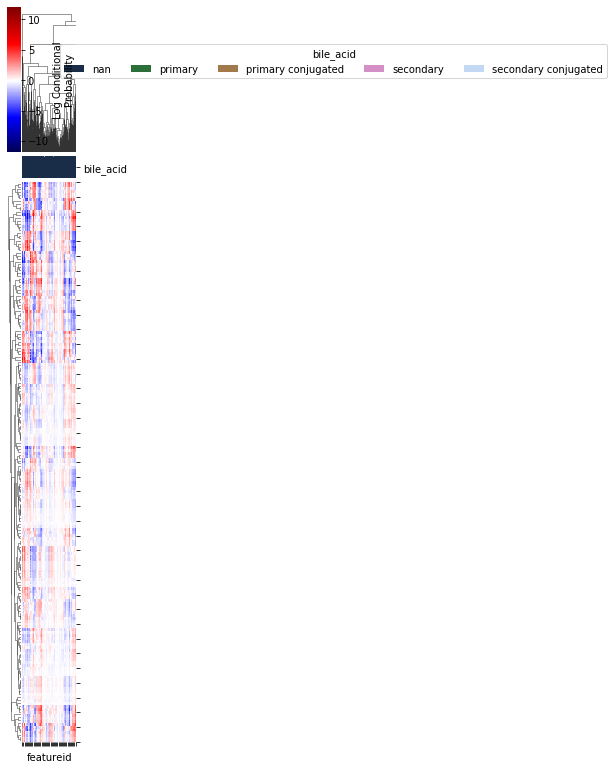

In [24]:
test = heatmap(ranks=mmvec_dict["Stool"]["conditionals"],
               #microbe_metadata=genera_qza,
               metabolite_metadata=met_md_q2.get_column("bile_acid"),
               method="average",
               metric="euclidean",
               level=-1,
               row_center=True)

In [36]:
mmvec_bile_dict

{'Stool': {}, 'Oral': {}, 'Skin': {}}

In [34]:
test_bile = heatmap(ranks=mmvec_bile_dict["Stool"]["conditionals"],
               #microbe_metadata=genera_qza,
               metabolite_metadata=met_md_q2.get_column("bile_acid"),
               method="average",
               metric="euclidean",
               level=-1,
               row_center=True)

KeyError: 'conditionals'

In [26]:
test.visualization

<visualization: Visualization uuid: 8cbeffe5-77a7-426f-89a6-aabe6bc28e61>